# Training the tabular dataset
In this script, we first trained an XGBoost classifier.

Then we performed the downstream SHAP and UMAP analysis.

In [1]:
import glob
import os
from pathlib import Path
import joblib
import time
import datetime
import platform
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

folder_name = 'v1.3_xgb_all'
NUM_GPU = 1
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

print('TensorFlow version:', tf.__version__)
print('Python =', platform.python_version())

data_pd = pd.read_csv('all_features.csv')
print('data_pd.shape =', data_pd.shape)
col_feature = data_pd.columns[2:]
print('Number of features =', col_feature.shape[0])

TensorFlow version: 2.18.0
Python = 3.12.4
data_pd.shape = (8280, 289)
Number of features = 287


In [3]:
# train test split
label_classes = [ 'PARENT', 'TREM2_KO', 'R47H', 'H157Y', 'PLCG2_KO',
    'P522R', 'P522R_HET', 'SHIP1_KO', 'ABI3_KO', 'S209F']
le = LabelEncoder()
data_pd['label'] = le.fit_transform(data_pd['label'])
print('label [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:', le.classes_)
train_pd, val_pd = train_test_split(data_pd, test_size=0.1, random_state=1, stratify=data_pd['label'])
print('train_pd.shape =', train_pd.shape)
print('val_pd.shape =', val_pd.shape)

# standardise data
train_pdd = train_pd.copy()
val_pdd = val_pd.copy()
data_pdd = data_pd.copy()

train_id = train_pdd.pop('rcfid')
val_id = val_pdd.pop('rcfid')

## add for all
train_plate_id = train_pdd.pop('plate_id')
val_plate_id = val_pdd.pop('plate_id')

train_labels = train_pdd['label'].to_numpy()
val_labels = val_pdd['label'].to_numpy()

train_pdd = train_pdd.drop('label', axis=1)
train_features = train_pdd.to_numpy()

val_pdd = val_pdd.drop('label', axis=1)
val_features = val_pdd.to_numpy()


# normalise data using z-score
# zscore = (train_pdd - train_pdd.mean())/train_pdd.std()
scaler = StandardScaler()
# data_np = data_pdd.drop(['label', 'rcfid'], axis=1).to_numpy()
# add for all
data_np = data_pdd.drop(['label', 'rcfid', 'plate_id'], axis=1).to_numpy()  
scaler.fit(data_np)
train_features = scaler.transform(train_features)
val_features = scaler.transform(val_features)
features_mean = scaler.mean_
features_std = scaler.scale_
print('train_features.shape =', train_features.shape)
print('val_features.shape', val_features.shape)

label [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: ['ABI3_KO' 'H157Y' 'P522R' 'P522R_HET' 'PARENT' 'PLCG2_KO' 'R47H' 'S209F'
 'SHIP1_KO' 'TREM2_KO']
train_pd.shape = (7452, 289)
val_pd.shape = (828, 289)
train_features.shape = (7452, 286)
val_features.shape (828, 286)


In [5]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space={'max_depth': hp.quniform('max_depth', 3, 18, 1),
       'gamma': hp.uniform ('gamma', 0, 9),
       'reg_alpha': hp.uniform('reg_alpha', 0, 100),
       'reg_lambda': hp.uniform('reg_lambda', 0, 5),
       'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
       'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 5, 1000, 5),
}

# Classifier:
def hyperparameter_tuning(space):
    model = xgb.XGBClassifier(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), 
                              gamma=space['gamma'], reg_alpha=int(space['reg_alpha']), 
                              min_child_weight=space['min_child_weight'],
                              colsample_bytree=space['colsample_bytree'],
                              eval_metric="merror",
                              early_stopping_rounds=10)
    evaluation = [(train_features, train_labels), (val_features, val_labels)]
    
    model.fit(train_features, train_labels, eval_set=evaluation, verbose=False)
    pred = model.predict(val_features)
    accuracy = accuracy_score(val_labels, pred)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)
print(best)

SCORE:                                                                          
0.45169082125603865                                                             
SCORE:                                                                          
0.40096618357487923                                                             
SCORE:                                                                          
0.38768115942028986                                                             
SCORE:                                                                          
0.572463768115942                                                               
SCORE:                                                                          
0.5869565217391305                                                              
SCORE:                                                                          
0.5471014492753623                                                              
SCORE:                      

In [8]:
# train
model = xgb.XGBClassifier(n_estimators=310, 
                          max_depth=7, 
                          gamma=0.64, 
                          reg_alpha=3.07, 
                          min_child_weight=2, 
                          colsample_bytree=0.26, 
                          reg_lambda=4.28)

# model = xgb.XGBClassifier()
path_model = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(path_model):
    os.makedirs(path_model)
path = os.path.join(path_model, 'model.joblib')
model.fit(train_features, train_labels)
joblib.dump(model, path, compress=9)

['/Users/zhuangzhuang/Desktop/Data Science Project/Task2/v1.3_xgb_all/model.joblib']

accuracy: 0.6219806763285024


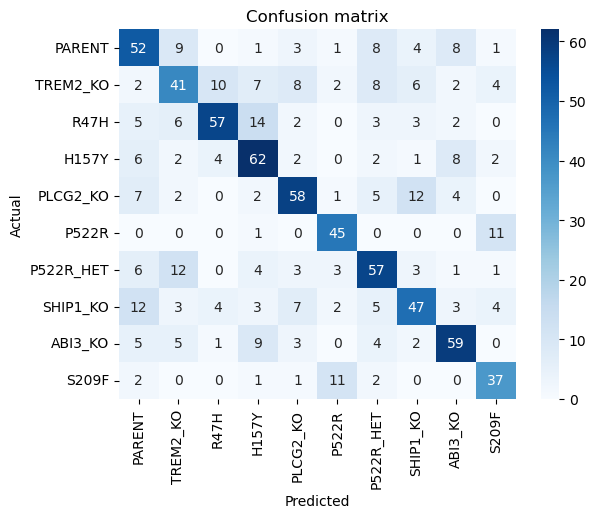

In [10]:
path = os.path.join(os.getcwd(), folder_name, 'model.joblib')
model = joblib.load(path)
label_pred = model.predict(val_features)
pred_pd = val_pd[['rcfid', 'label']].copy()
pred_pd['pred'] = label_pred
path = os.path.join(os.getcwd(), folder_name, 'prediction.csv')
pred_pd.to_csv(path, index=False)
print('accuracy:', accuracy_score(val_labels, label_pred))

# create confusion matrix
cf_matrix = confusion_matrix(val_labels, label_pred, labels=np.arange(len(label_classes)))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_classes, yticklabels=label_classes, linewidth=0)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

path_cf = os.path.join(os.getcwd(), 'results')
if not os.path.exists(path_cf):
   os.makedirs(path_cf)
cf_path = os.path.join(path_cf, 'cf_matrix_all.png')
plt.savefig(cf_path, dpi=300, bbox_inches='tight')

plt.show()

In [12]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_features)

In [14]:
shap_values[0].shape

(286, 10)

In [16]:
explainer.expected_value

[0.4938113,
 0.59167016,
 0.66137725,
 0.56121737,
 0.5279694,
 0.40623116,
 0.4992498,
 0.5771004,
 0.51017195,
 0.32514292]

In [18]:
label_classes

['PARENT',
 'TREM2_KO',
 'R47H',
 'H157Y',
 'PLCG2_KO',
 'P522R',
 'P522R_HET',
 'SHIP1_KO',
 'ABI3_KO',
 'S209F']

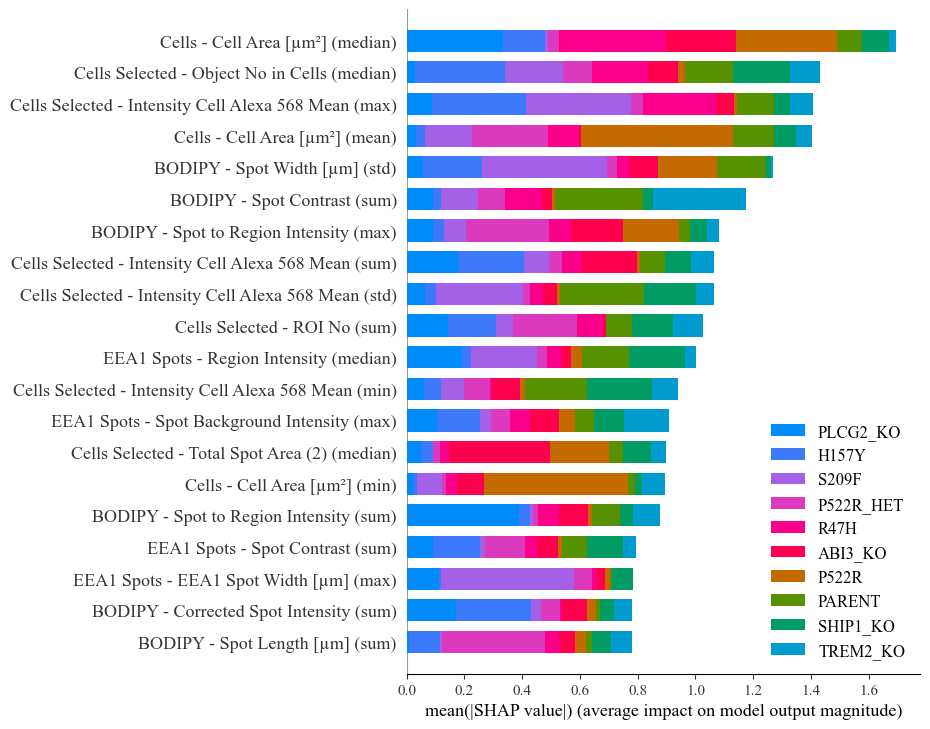

In [20]:
# Create SHAP figure
plt.figure(figsize=(50, 50))
plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.size'] = '30'
plt.rcParams.update({'font.size': 30}) 
shap.summary_plot(shap_values, train_features, plot_size=[10, 8], 
                 plot_type='bar', class_names=label_classes, feature_names=train_pd.columns[2:], show=False)

path_results = os.path.join(os.getcwd(), 'results')
if not os.path.exists(path_results):
   os.makedirs(path_results)
shap_path = os.path.join(path_results, 'shap_all.png')
plt.savefig(shap_path, bbox_inches='tight', dpi=300)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


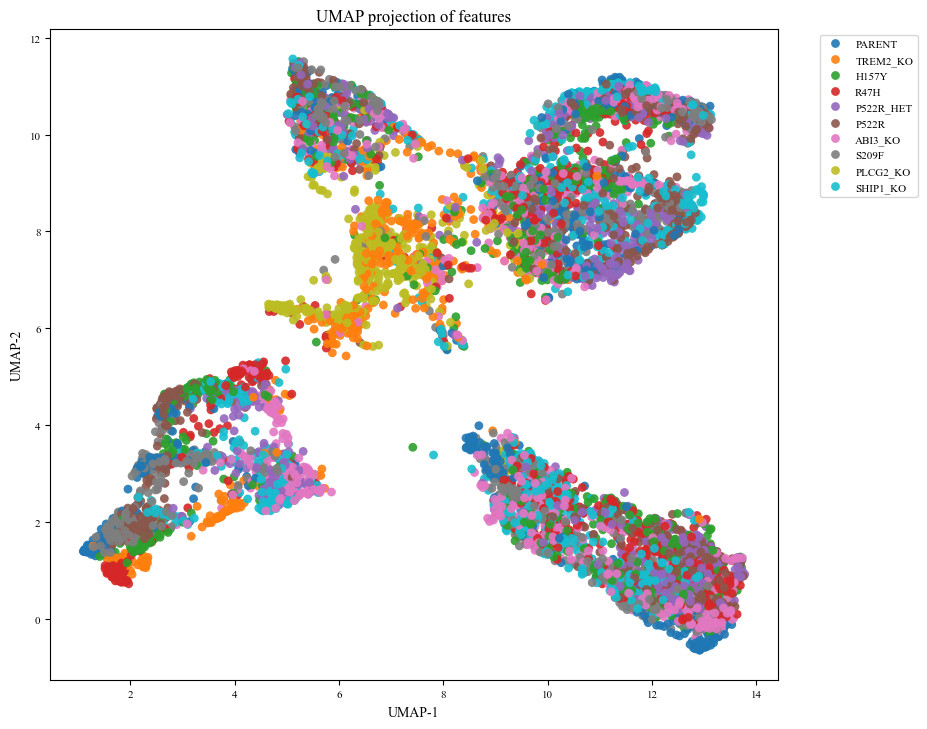

In [86]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

# load the dataset
data_pd = pd.read_csv('all_features.csv')

# Extract features and standardize

#features = data_pd.drop(['rcfid', 'label'], axis=1).fillna(0.0).astype(float)
features = data_pd.drop(['rcfid', 'label', 'plate_id'], axis=1).fillna(0.0).astype(float)
features_scaled = StandardScaler().fit_transform(features)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42)
embedding = reducer.fit_transform(features_scaled)

# Prepare labels
le_label = LabelEncoder()
label_encoded = le_label.fit_transform(data_pd['label'])

#le_plate = LabelEncoder()
#plate_encoded = le_plate.fit_transform(data_pd['plate_id'])

# Plot and save the UMAP figure: colored by labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1],
    hue=data_pd['label'],
    palette='tab10',
    s=40,
    edgecolor='none',
    alpha=0.9
)
plt.title('UMAP projection of features', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.xlabel('UMAP-1', fontsize=10)
plt.ylabel('UMAP-2', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.savefig('results/umap_all.png', dpi=300)
plt.show()

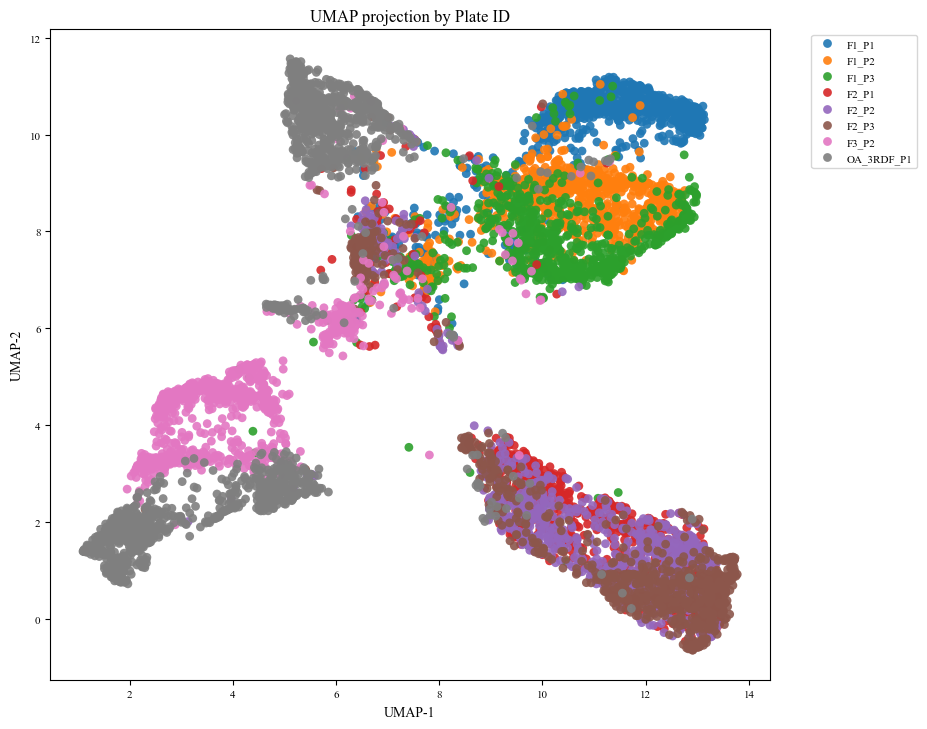

In [90]:
le_plate = LabelEncoder()
plate_encoded = le_plate.fit_transform(data_pd['plate_id'])

# Plot and save the second UMAP figure: colored by plate_id
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1],
    hue=data_pd['plate_id'],
    palette='tab10',
    s=40,
    edgecolor='none',
    alpha=0.9
)
plt.title('UMAP projection by Plate ID', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.xlabel('UMAP-1', fontsize=10)
plt.ylabel('UMAP-2', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.savefig('results/umap_by_plate.png', dpi=300)
plt.show()